In [ ]:
import sys
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
import keras
import numpy as np
import pandas as pd
#import config
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle as pkl
from PIL import Image
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('drive/My Drive/HousePrices/images_and_prices.pkl', 'rb') as f:
  data = pkl.load(f)

In [ ]:
data.drop(data[data['sqrt_persqm_lsoa_avg'] > 8000 ** 0.5].index, inplace=True)

In [ ]:
# Replace image for HP15 7TH
images = [x for x in data['image']]
postcodes = [x for x in data['postcode']]
to_replace_idx = postcodes.index('HP15 7TH')
replace_with_idx = postcodes.index('HP15 7TP')
images[to_replace_idx] = images[replace_with_idx]
data['image'] = images
del images

In [ ]:
# Split data geographically by LSOA
lsoa_list = list(data['lsoa_code'].unique())

# Use 15 % of LSOAs as test data
n_test_lsoas = int(len(lsoa_list) * 0.15)
print(f'Number of training LSOAs: {len(lsoa_list) - n_test_lsoas}')
print(f'Number of test LSOAs: {n_test_lsoas}')
random.seed(1)
test_lsoas= random.sample(lsoa_list, n_test_lsoas)
test = data[data['lsoa_code'].isin(test_lsoas)]
train = data[~data['lsoa_code'].isin(test_lsoas)]
original_train_index = train.index
print(f'{train.shape[0]} train samples, {test.shape[0]} test samples')

Number of training LSOAs: 60
Number of test LSOAs: 10
1022 train samples, 170 test samples


In [ ]:
test_lsoas

['E01017935',
 'E01017904',
 'E01017900',
 'E01017858',
 'E01017871',
 'E01017867',
 'E01017938',
 'E01017859',
 'E01017936',
 'E01017907']

In [ ]:
# create geographically separate validation set

train_lsoas = list(train['lsoa_code'].unique())

n_val_lsoas = int(len(train_lsoas) * 0.1)
print(f'Number of training LSOAs: {len(train_lsoas) - n_val_lsoas}')
print(f'Number of validation LSOAs: {n_val_lsoas}')
random.seed(1)
val_lsoas = random.sample(train_lsoas, n_val_lsoas)
val = train[train['lsoa_code'].isin(val_lsoas)]
train = train[~train['lsoa_code'].isin(val_lsoas)]
print(f'{train.shape[0]} training samples')
print(f'{test.shape[0]} test samples')

Number of training LSOAs: 54
Number of validation LSOAs: 6
905 training samples
170 test samples


In [ ]:
# Training data
X_train = np.array([list(x) for x in train['image'].values]).astype(np.int32)
y_train = train['sqrt_persqm_lsoa_avg']

# Create validation set from training data
# X_val = X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

X_val = np.array([list(x) for x in val['image'].values]).astype(np.int32)
y_val = val['sqrt_persqm_lsoa_avg']

# Test data
X_test = np.array([list(x) for x in test['image'].values]).astype(np.int32)
y_test = test['sqrt_persqm_lsoa_avg']

## Train models

In [ ]:
from keras.applications import ResNet50, InceptionResNetV2, DenseNet201


In [ ]:
input_shape = (128, 128, 3)

In [ ]:
def basic_normalize(arr):
  return arr / 255

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input as rn50_pre
from tensorflow.keras.applications.densenet import preprocess_input as dn_pre
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as irv2_pre

In [ ]:
basic_model = Sequential()
basic_model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='valid',
activation='relu', input_shape=input_shape))
basic_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
basic_model.add(BatchNormalization())
basic_model.add(Dropout(0.1))
basic_model.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
basic_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
basic_model.add(BatchNormalization())
basic_model.add(Dropout(0.1))
basic_model.add(Conv2D(64, (7, 7), activation='relu', strides=(2,2), padding='valid'))
basic_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
basic_model.add(BatchNormalization())
basic_model.add(GlobalAveragePooling2D())
basic_model.add(Dropout(0.5))
basic_model.add(Dense(1, activation='relu'))
basic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        1

In [ ]:

model_list = [
  basic_model,
  DenseNet201,
  ResNet50,
  InceptionResNetV2
  ]

model_names = [
  'BasicCNN',
  'DenseNet201',
  'ResNet50',
  'InceptionResNetV2'
  ]

preprocess_funcs = [
  basic_normalize,
  dn_pre,
  rn50_pre,
  irv2_pre
  ]

histories = []

test_errors = test[['postcode', 'lsoa_code']]
test_index = test.index


In [ ]:

for i in range(len(model_list)):
  m = model_list[i]
  model_name = model_names[i]

  X__train_preprocessed = preprocess_funcs[i](X_train)
  X_val_preprocessed = preprocess_funcs[i](X_val)

  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True)

  datagen.fit(X__train_preprocessed)
  batch_size = 20
  it = datagen.flow(X__train_preprocessed, y_train, batch_size=batch_size)

  if i > 0:
    loaded_model = m(weights='imagenet', include_top=False, input_shape=(input_shape))

    for layer in loaded_model.layers:
      layer.trainable = False

    model = Sequential()
    model.add(loaded_model)

    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

  else:
    model = m

  filepath=f'drive/My Drive/HousePrices/model checkpoints/{model_name}'

  callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=filepath,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
  )
      
  gc.collect()
  opt = 'adam'
  loss = 'mse'
  epochs = 30
  tf.random.set_seed(1)
  model.compile(optimizer=opt, loss=loss)
  # fit the model
  history = model.fit(
      it,
      steps_per_epoch=math.ceil(len(X_train) / batch_size),
      epochs=epochs,
      verbose=2,
      shuffle=True,
      validation_data=(X_val_preprocessed, y_val),
      callbacks=[callback]
    )
  
  histories.append(history)

  plt.figure(figsize=(10,6))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('epoch')
  plt.ylabel('loss (MAE)')
  plt.title(f'{model_name}')
  plt.legend(['training loss', 'validation loss'])
  plt.savefig(f'drive/My Drive/HousePrices/cleaned_train_validation_loss_{model_name}.png')


BasicCNN - mae: 444.85147779247814
BasicCNN - Correlation score: 0.23310034138428187


KeyboardInterrupt: ignored

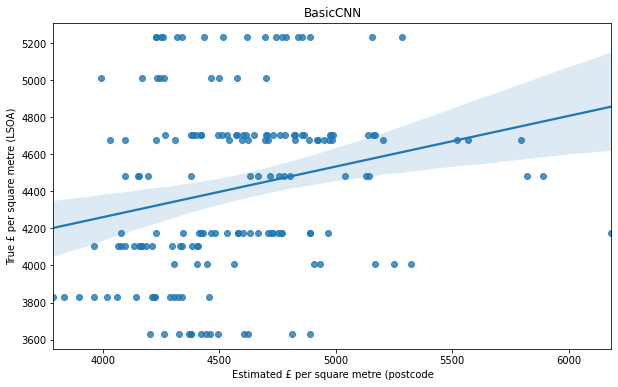

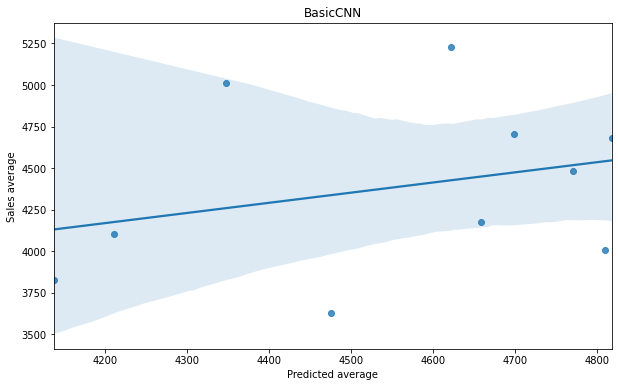

In [ ]:
correl = []
mae = []
avg_correl = []

for i in range(len(model_list)):

  model_name = model_names[i]
  filepath = f'drive/My Drive/HousePrices/model checkpoints/{model_name}'  
  model = tf.keras.models.load_model(filepath)

  X_test_preprocessed = preprocess_funcs[i](X_test)

  y_pred = (model.predict(X_test_preprocessed) ** 2)
  y_pred = y_pred.reshape(1, len(y_pred))[0]
  y_true = y_test ** 2

  errors = abs(y_pred - y_true) / y_true * 100

  cols = list(test_errors.columns).append(f'{model_name}_errors')
  test_errors = (
      pd.DataFrame(
          pd.concat(
            [test_errors, errors],
            axis=1,
            ignore_index=True
          ),
          columns=cols,
          index=test.index
      )
  )

  plt.figure(figsize=(10,6))
  sns.regplot(y_pred, y_true)
  plt.title(f'{model_name}')
  plt.xlabel('Estimated £ per square metre (postcode')
  plt.ylabel('True £ per square metre (LSOA)')
  plt.savefig(f'drive/My Drive/HousePrices/cleaned_postcode_pred_vs_lsoa_actual_{model_name}.png')

  mae_score = mean_absolute_error(y_true, y_pred)
  mae.append(mae_score)
  correl_score = np.corrcoef(y_pred, y_true)[0,1]
  correl.append(correl_score)
  print(f'{model_name} - mae: {mae_score}')
  print(f'{model_name} - Correlation score: {correl_score}')

  pred_table = pd.concat([test[['postcode','lsoa_code']].reset_index(drop=True),
                        pd.Series(y_pred),
                        pd.Series(y_true).reset_index(drop=True)],
                        axis=1,
                        ignore_index=True)
  pred_table.columns = ['postcode', 'lsoa_code', 'y_pred', 'y_true']

  avgs = pred_table[['lsoa_code', 'y_pred', 'y_true']].groupby('lsoa_code').mean()

  plt.figure(figsize=(10,6))
  sns.regplot(x='y_pred', y='y_true', data=avgs)
  plt.title(f'{model_name}')
  plt.xlabel('Predicted average')
  plt.ylabel('Sales average')
  plt.savefig(f'drive/My Drive/HousePrices/cleaned_avg_pred_true_by_lsoa_{model_name}.png')

  avg_correl_score = np.corrcoef(avgs['y_true'], avgs['y_pred'])[0,1]
  avg_correl.append(avg_correl_score)


In [ ]:
df = pd.DataFrame.from_records(zip(mae, correl, avg_correl),
                               index=model_names,
                               columns=['mae', 'correlation', 'lsoa_avg_correlation'])

df.sort_values('mae', inplace=True)
df.to_csv('drive/My Drive/HousePrices/cleaned_cnn_scores.csv')
df

In [ ]:
pc_centres = pd.read_csv('drive/My Drive/HousePrices/hp_postcode_centres.csv').drop('point', axis=1)

In [ ]:
error_cols = [f'{s}_error' for s in model_names]
test_errors.columns = ['postcode', 'lsoa_code']  + error_cols

In [ ]:
if not 'lat' in train.columns:
  #train = pd.concat([train, val])
  train = train.merge(pc_centres, how='left', left_on='postcode', right_on='postcode')
  val = val.merge(pc_centres, how='left', left_on='postcode', right_on='postcode')

In [ ]:
val[val['lat'].isnull()]

,postcode,lsoa_code,sqrt_persqm_lsoa_avg,image,lat,lon


In [ ]:
if not 'lat' in test_errors.columns:
  test_errors = test_errors.merge(pc_centres, how='left', left_on='postcode', right_on='postcode')

test_errors.head()

,postcode,lsoa_code,BasicCNN_error,DenseNet201_error,ResNet50_error,InceptionResNetV2_error,lat,lon
0,HP12 3DG,E01017904,10.231745,1.834927,7.311465,3.099643,51.632610,-0.769371
1,HP12 3FP,E01017904,12.019809,25.060506,10.694094,72.671292,51.631911,-0.774286
2,HP12 3BD,E01017904,3.402867,28.566490,29.210066,3.982809,51.634422,-0.771083
3,HP12 3HG,E01017904,5.986639,18.026364,6.200342,20.076503,51.631566,-0.771276
4,HP12 3EY,E01017904,13.266217,27.788170,12.693548,3.334355,51.631761,-0.772007


In [ ]:
def distance(p1, p2):
  
  """Calculate distance between two lat lon pairs"""
  
  x1 = math.radians(p1[0])
  x2 = math.radians(p2[0])
  dx = math.radians(p2[0] - p1[0])
  dy = math.radians(p2[1] - p1[1])
  
  a = math.sin(dx/2)**2 + math.cos(x1) * math.cos(x2) * math.sin(dy/2)**2
  
  c = 2 * math.atan2(a**0.5, (1-a)**0.5)
  
  return 6378 * c

In [ ]:

train_dropna = train.dropna(subset=['lat'])
train_lat_lon = list(zip(train_dropna['lat'], train_dropna['lon']))
test_lat_lon = list(zip(test_errors.dropna()['lat'], test_errors.dropna()['lon']))

In [ ]:
train[train['lat'].isnull()]

,postcode,lsoa_code,sqrt_persqm_lsoa_avg,image,lat,lon
226,HP11 1BW,E01017910,64.913784,"[[[96, 104, 80], [106, 112, 89], [106, 112, 89...",NaN,NaN
234,HP11 1FD,E01017910,64.913784,"[[[36, 42, 33], [20, 34, 17], [36, 50, 32], [5...",NaN,NaN


In [ ]:
dists = [np.mean(sorted([distance(x, y) for y in train_lat_lon])[:3]) for x in test_lat_lon]
test_errors.dropna()[np.array(dists) > 2]

,postcode,lsoa_code,BasicCNN_error,DenseNet201_error,ResNet50_error,InceptionResNetV2_error,lat,lon


In [ ]:
test_dropna = test_errors.dropna()
test_dropna['avg_dist_nearest_3'] = dists
test_dropna.sort_values('avg_dist_nearest_3', inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test_dropna

,postcode,lsoa_code,BasicCNN_error,DenseNet201_error,ResNet50_error,InceptionResNetV2_error,lat,lon,avg_dist_nearest_3
33,HP10 0FH,E01017935,0.036635,30.564851,5.407875,15.711026,51.597360,-0.682497,0.059329
13,HP12 3DN,E01017904,1.104026,16.547932,2.568660,29.116008,51.633427,-0.768798,0.094730
161,HP15 6BH,E01017871,12.533431,15.283779,21.072641,58.747704,51.663782,-0.717413,0.096035
122,HP12 4RN,E01017907,20.596648,25.297329,4.107630,46.438161,51.622045,-0.784433,0.096205
83,HP13 7ET,E01017900,10.998841,19.255156,24.103420,40.195282,51.625109,-0.714993,0.099052
...,...,...,...,...,...,...,...,...,...
74,HP10 0JA,E01017936,18.767072,2.999846,4.709584,7.571515,51.580634,-0.687268,1.499105
66,HP10 0PR,E01017936,11.729249,8.835854,15.440260,67.010294,51.579350,-0.690609,1.505171
67,HP10 0PY,E01017936,8.515563,40.722182,1.616640,57.596339,51.579403,-0.689713,1.531255
75,HP10 0JP,E01017936,7.201695,39.209718,18.277596,71.984536,51.581061,-0.675666,1.568913


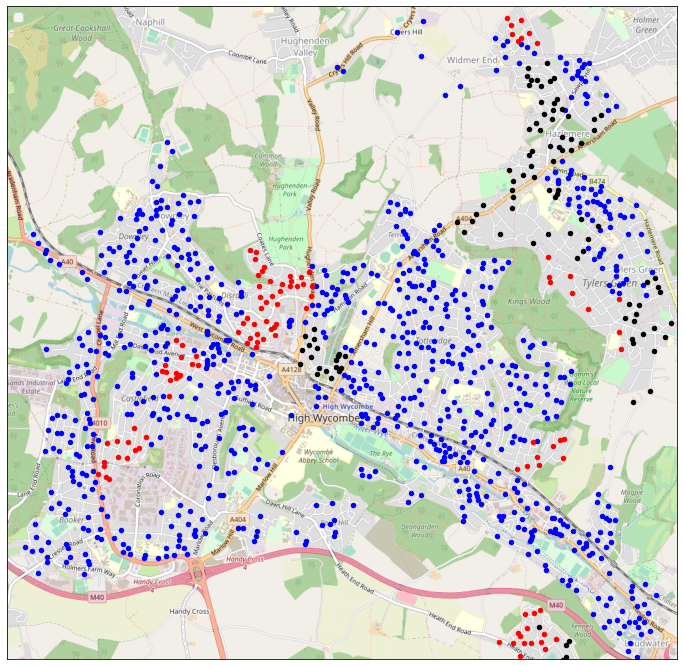

In [ ]:
BBox = (-0.7989, -0.6921, 51.6042, 51.6671)
hwyc = plt.imread('drive/My Drive/HousePrices/high wycombe map.png')
fig, ax = plt.subplots(figsize = (12,12))
ax.imshow(hwyc, zorder=0, extent = BBox, aspect='auto')
ax.scatter(train_dropna['lon'], train_dropna['lat'], zorder=1, c='blue', s=20)
ax.scatter(val['lon'], val['lat'], zorder=1, c='black', s=20)
ax.scatter(test_dropna['lon'], test_dropna['lat'], zorder=1, c='r', s=20)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False,
    left=False,
    labelleft=False)
labels = ['Training', 'Validation', 'Test']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, loc='upper left', fontsize='large')
plt.savefig('drive/My Drive/HousePrices/highwycombetraintestplot.png')
plt.show()

In [ ]:
max_dist = test_dropna.avg_dist_nearest_3.max()
min_dist = test_dropna.avg_dist_nearest_3.min()

n_bins = 10

bins = pd.cut(test_dropna.avg_dist_nearest_3, np.linspace(min_dist, max_dist, n_bins))
grouped_errors = test_dropna.groupby(bins)[error_cols].mean()
melted = pd.melt(grouped_errors.reset_index(), id_vars='avg_dist_nearest_3').set_index('avg_dist_nearest_3')

In [ ]:
melted2 = melted[melted['variable'].isin(['ResNet50_error', 'BasicCNN_error'])]
melted2

,variable,value
avg_dist_nearest_3,,
"(0.0593, 0.228]",BasicCNN_error,9.387158
"(0.228, 0.397]",BasicCNN_error,11.451670
"(0.397, 0.565]",BasicCNN_error,11.120251
"(0.565, 0.734]",BasicCNN_error,7.019483
"(0.734, 0.903]",BasicCNN_error,3.601533
"(0.903, 1.072]",BasicCNN_error,12.066929
"(1.072, 1.24]",BasicCNN_error,10.234758
"(1.24, 1.409]",BasicCNN_error,17.808599
"(1.409, 1.578]",BasicCNN_error,12.578582


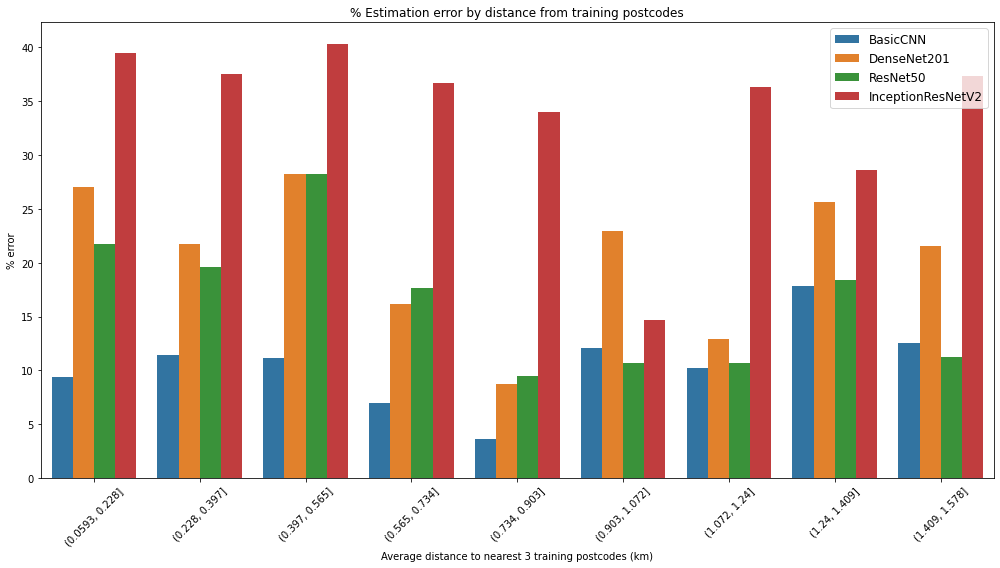

In [ ]:
plt.figure(figsize=(14,8))
ax1 = sns.barplot(x=melted.index, y='value', data=melted, hue='variable')
plt.xlabel('Average distance to nearest 3 training postcodes (km)')
plt.ylabel('% error')
plt.title('% Estimation error by distance from training postcodes')
for x in ax1.get_xticklabels():
    x.set_rotation(45)
labels = model_names
h, l = ax1.get_legend_handles_labels()
ax1.legend(h, labels, loc='upper right', fontsize='large')
plt.tight_layout()
plt.savefig('drive/My Drive/HousePrices/cleaned_all_models_error_vs_dist.png')
plt.show()

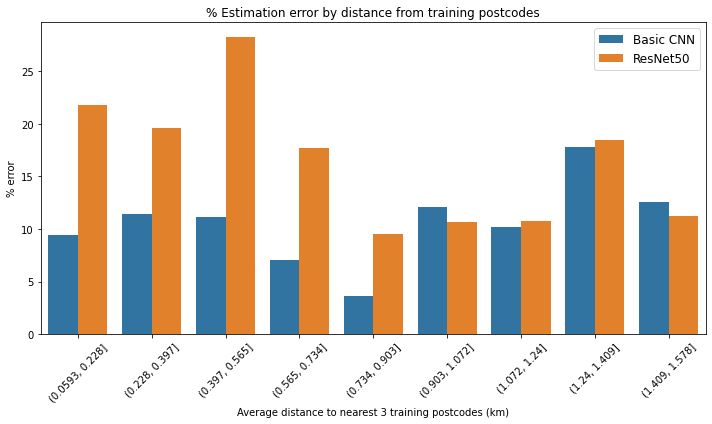

In [ ]:
plt.figure(figsize=(10,6))
ax1 = sns.barplot(x=melted2.index, y='value', data=melted2, hue='variable')
plt.xlabel('Average distance to nearest 3 training postcodes (km)')
plt.ylabel('% error')
plt.title('% Estimation error by distance from training postcodes')
for x in ax1.get_xticklabels():
    x.set_rotation(45)
labels = ['Basic CNN', 'ResNet50']
h, l = ax1.get_legend_handles_labels()
ax1.legend(h, labels, loc='upper right', fontsize='large')
plt.tight_layout()
plt.savefig('drive/My Drive/HousePrices/cleaned_selected_models_error_vs_dist.png')
plt.show()

In [ ]:
X_train = np.array([list(x) for x in train['image'].values]).astype(np.int32) / 255

In [ ]:
X_train.shape

(979, 128, 128, 3)

Extracting features with two chosen models

In [ ]:
with open('drive/My Drive/HousePrices/images_and_prices.pkl', 'rb') as f:
  data = pkl.load(f)

In [ ]:
model_names = ['BasicCNN', 'ResNet50']

for i in range(2):
  model_name = model_names[i]
  filepath=f'drive/My Drive/HousePrices/model checkpoints/{model_name}'
  model = tf.keras.models.load_model(filepath)
  all_images = np.array([list(x) for x in data['image'].values]).astype(np.int32)
  all_images = preprocess_funcs[i](all_images)

  feature_model = Sequential()

  for layer in model.layers[:-1]:
    feature_model.add(layer)

  for layer in feature_model.layers:
    layer.trainable = False

  features = feature_model.predict(all_images)

  features_df = pd.DataFrame.from_records(list(zip(data.postcode, features)), columns=['postcode', 'features'])
  features_df = pd.DataFrame(features_df['features'].to_list(), index=features_df.postcode)
  features_df.to_pickle(f'drive/My Drive/HousePrices/visual_features_{model_name}.pkl')